# SISTA IOT Implementation between X points and Y points in [0, 1] (R2)

Hyperparameters :
*   n number of X elements
*   m number of Y elements
*   seedX : a number to fix the random seed to generate X , or None to not use a seed
*   seedY : a number to fix the random seed to generate Y, or None to not use a seed

## Imports

In [ ]:
#Maths
import numpy as np
import math
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
#data handling
import pandas as pd

## Hyperparameters

In [ ]:
n = 10
m = 15
seedX = None
seedY = None

## Preprocessing

### Data and plotting

In [ ]:
# Generate n and m points to create X and Y
if seedX is not None : 
    np.random.seed(int(seedX))

X = np.random.rand(n,2)

if seedY is not None : 
    np.random.seed(int(seedY))
Y = np.random.rand(m,2)

X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

### Functions Definition

In [ ]:
# Returns the R2 norm between 2 points
def norm(xi, yi):
    return math.sqrt( (xi[0] - yi[0])**2 + (xi[1] - yi[1])**2 )

In [ ]:
# Returns the Cost Matrix to link X to Y
def costM(X, Y):
    n = len(X[0])
    m = len(Y[0])
    M = np.zeros((n, m))
    for i in range(n):
      for j in range(m):
        M[i][j] = norm(X.iloc[i], Y.iloc[j])
    return M

def Sinkhorn(C,a,b,epsilon,niter = 500):
    K=np.exp(-C/epsilon)
    v=np.ones(b.size)
    for it in range(niter):
        u=a/(np.dot(K,v))
        v=b/(np.dot(K.T,u))
    P = np.dot(np.diag(u),np.dot(K,np.diag(v)))
    return P

#SISTA multi dim (dim = k) 

### Functions Definition

In [ ]:
dim_k=1 #number of features to evaluate dissimilarity, in our simple case k=1

def Vec_MatOfVec_product(vec,matOfVec):
  C=np.zeros((matOfVec.shape[0],matOfVec.shape[1]))
  for i in range(matOfVec.shape[0]):
    for j in range(matOfVec.shape[1]):
        C[i,j]=np.dot(vec,matOfVec[i,j])
  return C

SISTA ALGORITHM:
- - - - - - 

Input: Initial guess of parameter vector $\beta^{0}$, of potentials $u^{0}$ and $v^{0}$, step size $\tau$, and dissimilarity measures $d_{i j}^{k}$
while not converged do
(Sinkhorn step). Set $c_{i j}^{\beta^{t}}:=\sum_{k=1}^{K} \beta_{k}^{t} d_{i j}^{k}$ and update:
$$
\left\{\begin{aligned}
\exp \left(u_{i}^{t+1}\right) &=\frac{p_{i}}{\sum_{j=1}^{N} \exp \left(v_{j}^{t}-c_{i j}^{\beta^{t}}\right)} \\
\exp \left(v_{j}^{t+1}\right) &=\frac{q_{j}}{\sum_{i=1}^{N} \exp \left(u_{i}^{t+1}-c_{i j}^{\beta^{t}}\right)}
\end{aligned}\right.
$$
(ISTA step). Let $\pi_{i j}^{\beta^{t}}:=\exp \left(u_{i}^{t+1}+v_{j}^{t+1}-c_{i j}^{\beta^{t}}\right) .$ For $k=1, \ldots, K$
$$
\beta_{k}^{t+1}=\operatorname{prox}_{\rho \gamma|\cdot|}\left(\beta_{k}^{t}-\tau \sum_{1 \leq i, j \leq N}\left(\hat{\pi}_{i j}-\pi_{i j}^{\beta^{t}}\right) d_{i j}^{k}\right)
$$
end while
Return: $\beta$
- - - - - - 
Note that:

$$
\operatorname{prox}_{\rho \gamma|\cdot|}(z)= \begin{cases}z-\rho \gamma & \text { if } z>\rho \gamma \\ 0 & \text { if }|z| \leq \rho \gamma \\ z+\rho \gamma & \text { if } z<-\rho \gamma\end{cases}
$$

In [ ]:
def SISTA_multi_d(P,D,mu,nu,dim_k): # D=(D)i,j is dissimilarity matrix of vectors (with size k vectors so D=matrix of vectors (n,m,k) and ß is a vector) between user i and movie j
  
  ß=u=np.ones(dim_k)
  u=np.ones(mu.size)
  v=np.ones(nu.size)
  P_ß=np.random.rand(mu.size,nu.size)
  tau=0.0001
  gamma=0.001 #regularization param

  for i in range(500):

    C=Vec_MatOfVec_product(ß,D)

    ## compute u and v
    for ii in range(u.size):
      u[ii]=np.log(mu[ii]/np.exp(v-C[ii,:]).sum())
    
    for jj in range(v.size):
      v[jj]=np.log(nu[jj]/np.exp(u-C[:,jj]).sum())

    ## compute P_ß
    for ii in range(P.shape[0]): #P shape same for u,v size and mu,nu size
      for jj in range(P.shape[1]):
        P_ß[ii,jj]=np.exp(u[ii]+v[jj]-C[ii,jj])

    ## compute ß with prox ß
    for k in range(dim_k):
      z=ß[k]-tau*((P-P_ß)*D[:,:,k]).sum()
      
      if z > tau*gamma:
        ß[k]=z-tau*gamma
      if np.abs(z) <= tau*gamma:
        ß[k]=0
      if z < -tau*gamma:
        ß[k]=z+tau*gamma

  return ß



### Plot and tests

Parameters

In [ ]:
#Parameters
a=np.ones(n)*1/n #constraint vector a
b=np.ones(m)*1/m #constraint vector b
epsilon=0.15 #Wheight coeff of entropic regularization
n_iter=1000

Matrix definition

In [ ]:
# We initialize the cost Matrix with the uniform matrix
C_Cost = costM(X, Y)

#Computes the transport matrix 'P_sink' from cost matrix 'C_Cost' using ROT and Sinkhorn algo
P_sink = Sinkhorn(Cost,a,b,epsilon,n_iter)

#compute Sista Cost Matrix 'C_sista' from 'P_sink' to see if we retrieve the original 'C_Cost' matrix
ß=SISTA_multi_d(P_sink,C_Cost[:,:,None],a,b,dim_k)
C_sista=Vec_MatOfVec_product(ß,C_Cost[:,:,None])

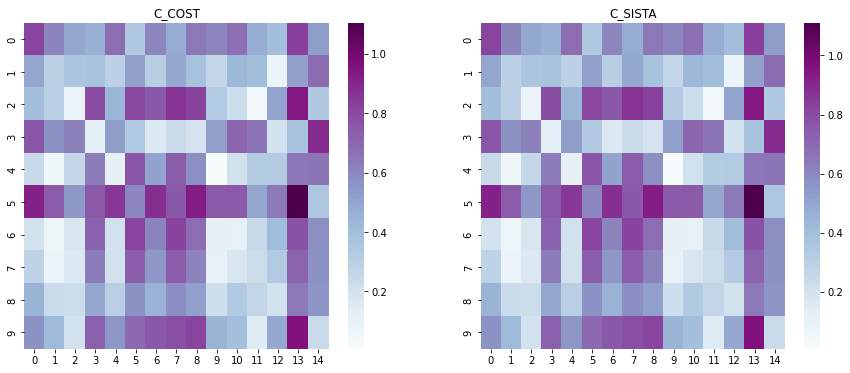

(0.33589329236285326, 0.33383731920742943)

In [ ]:
#plot the heatmaps
fig, axs = plt.subplots(1,2,figsize = (15, 6))
sns.heatmap(C_Cost, cmap="BuPu", ax=axs[0])
axs[0].title.set_text('C_COST')
sns.heatmap(C_sista, cmap="BuPu", ax=axs[1])
axs[1].title.set_text('C_SISTA')
plt.show()

(P_sink*C_sista).sum(), (P_sink*(C_Cost)).sum()

We run 10 times this experience to get the average error on Cost matrices estimation

In [ ]:
#calculates the mean error on 10 runs

rng=np.linspace(1,10,10)
ERR=[]
for i in range(len(rng)):

  XX = pd.DataFrame(np.random.rand(n,2))
  YY = pd.DataFrame(np.random.rand(m,2))

  CCost = costM(XX, YY)

  PP_sink = Sinkhorn(CCost,a,b,epsilon,n_iter) #compute the transport plan P from the Sinkhorn algorithm
  ßß=SISTA_multi_d(PP_sink,CCost[:,:,None],a,b,dim_k)
  CC_sista=Vec_MatOfVec_product(ßß,CCost[:,:,None])
  ERR.append((PP_sink*CC_sista).sum()-(PP_sink*CCost).sum())

np.mean(ERR)

0.0025081197757113537